<a href="https://colab.research.google.com/github/KoraySali/Dissertation_Archive/blob/main/model_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Image Detection Dissertation**

This file will include a number of important architectures, code and technologies. A Convolutional Neural Network (CNN) model will be used for the image detection of "Fire", "Smoke", "No Fire/No Smoke" classification.

A chosen methodology will be followed in order to prevent confusion when writting and coding this dissertation. Various evaluation metrics will be used to evaluate the outcome of the image detection model along with a number of visualisations for readability.

For copy/version issues a Github repository has been set up in order to retain versions and prevent loss of work.

The runtime of this file will be GPU as a CPU runtime took a lot longer to perform/execute our code.

In [ ]:
!git clone https://github.com/KoraySali/Dissertation_Archive.git

Cloning into 'Dissertation_Archive'...
remote: Enumerating objects: 11972, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 11972 (delta 36), reused 147 (delta 35), pack-reused 11820
Receiving objects: 100% (11972/11972), 51.20 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (12005/12005), done.


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.init(project='Visualisations 1')

wandb: Currently logged in as: s5216739 (s5216739-koray). Use `wandb login --relogin` to force relogin


## Importing our modules and libraries



In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image
import os
import cv2
import matplotlib.image as mpimg
import random
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import shutil
from skimage import io, transform
import time
import tensorflow_hub as hub

%matplotlib inline

## Select images in the folder

In [ ]:
def select_images_in_folder(preprocessed_folders):
    all_images = []

    for image_file in os.listdir(preprocessed_folders):
        read_image_path = os.path.join(preprocessed_folders, image_file)

        if os.path.isfile(read_image_path) is not None:
            single_image = mpimg.imread(read_image_path)
            all_images.append(single_image)
        else:
          print("Cannot return any images from " + preprocessed_folders)

    return all_images

In [ ]:
preprocessed_train_fire_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_fire")
preprocessed_train_smoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_smoke")
preprocessed_train_nofire_nosmoke_images = select_images_in_folder("/content/Dissertation_Archive/preprocessed_dataset/train_nofire_nosmoke")

In [ ]:
len(preprocessed_train_fire_images)

4000

# 1. Label Encoding 

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_names = ['Fire', 'No Fire or Smoke', 'Smoke']
Label_encoder = LabelEncoder()
Label_encoder.fit(label_names)
train_fire_labels = Label_encoder.transform(['Fire'] * len(preprocessed_train_fire_images))
train_nofire_nosmoke_labels = Label_encoder.transform(['No Fire or Smoke'] * len(preprocessed_train_nofire_nosmoke_images))
train_smoke_labels =  Label_encoder.transform(['Smoke'] * len(preprocessed_train_smoke_images))

In [ ]:
type(label_names)

list

# One-hot encoding labels

In [ ]:
from keras.utils import to_categorical

train_fire_labels = [0 for i in range(len(preprocessed_train_fire_images))]
train_smoke_labels = [1 for i in range(len(preprocessed_train_smoke_images))]
train_nofire_nosmoke_labels = [2 for i in range(len(preprocessed_train_nofire_nosmoke_images))]

# One-hot encoding the labels using keras library
train_fire_labels = tf.keras.utils.to_categorical(train_fire_labels, num_classes=3)
train_smoke_labels =  tf.keras.utils.to_categorical(train_smoke_labels, num_classes=3)
train_nofire_nosmoke_labels =  tf.keras.utils.to_categorical(train_nofire_nosmoke_labels, num_classes=3)

Checks done below to ensure the correct coding of the labels.

In [ ]:
train_fire_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
preprocessed_train_fire_images[0].shape

(128, 128, 3)

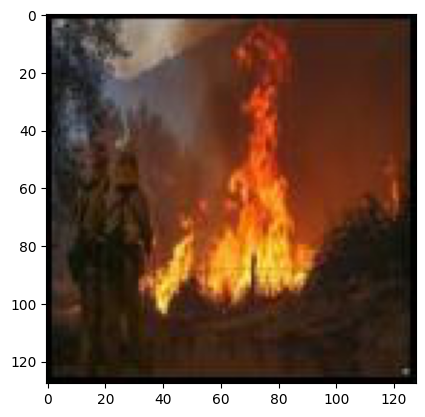

In [ ]:
for single_image in preprocessed_train_fire_images[:10]:
  plt.imshow(single_image)

# 2. Training and testing split for our model to use

This is slightly redundant as we do this in our Google Colaboratory file so when running this code skip this as there becomes no need.

In [ ]:
# Combining the preprocessed images and their labels

X_train = np.concatenate([preprocessed_train_fire_images, preprocessed_train_smoke_images, preprocessed_train_nofire_nosmoke_images])
y_train = np.concatenate([train_fire_labels, train_smoke_labels, train_nofire_nosmoke_labels])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


In [ ]:
mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

In [ ]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (9600, 128, 128, 3)
Train labels shape:  (9600,) int64
Test data shape:  (2400, 128, 128, 3)
Test labels shape:  (2400,)


# 3. Base Model Creation

Below is the first base model.

In [ ]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [ ]:
base_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_base = base_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 4. Complete Model

Below is the creation of our model and other relevant steps taken to achieve this.

## Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 50,
    zoom_range = 0.5,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,  
    vertical_flip=True)

In [ ]:
complete_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[128,128,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [ ]:
# wandb_callback = wandb.keras.WandbCallback()
complete_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_complete = complete_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
300/300 [==============================] - 32s 46ms/step - loss: 0.2730 - accuracy: 0.8984 - val_loss: 0.3951 - val_accuracy: 0.8396
Epoch 2/10
300/300 [==============================] - 14s 47ms/step - loss: 0.1812 - accuracy: 0.9335 - val_loss: 0.2078 - val_accuracy: 0.9054
Epoch 3/10
300/300 [==============================] - 14s 47ms/step - loss: 0.1374 - accuracy: 0.9496 - val_loss: 0.1502 - val_accuracy: 0.9425
Epoch 4/10
300/300 [==============================] - 14s 47ms/step - loss: 0.1096 - accuracy: 0.9601 - val_loss: 2.3066 - val_accuracy: 0.5508
Epoch 5/10
300/300 [==============================] - 14s 48ms/step - loss: 0.0943 - accuracy: 0.9654 - val_loss: 0.1504 - val_accuracy: 0.9442
Epoch 6/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0655 - accuracy: 0.9786 - val_loss: 0.1743 - val_accuracy: 0.9429
Epoch 7/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0647 - accuracy: 0.9768 - val_loss: 0.2150 - val_accuracy:

# 5. Machine Learning Pipelines

In [ ]:
train_features = complete_model.predict(X_train)
test_features = complete_model.predict(X_test)

75/75 [==============================] - 1s 15ms/step


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def make_pipeline(classifier, **kwargs):
    steps = [("scaler", StandardScaler()), ("classifier", classifier(**kwargs))]
    return Pipeline(steps)

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = make_pipeline(RandomForestClassifier, n_estimators=100)
svm_pipeline = make_pipeline(SVC, kernel="linear", C=1.0)
dt_pipeline = make_pipeline(DecisionTreeClassifier, max_depth=5, random_state=42)
knn_pipeline = make_pipeline(KNeighborsClassifier, n_neighbors=5)
nb_pipeline = make_pipeline(GaussianNB)

In [ ]:
rf_pipeline.fit(train_features, y_train)
svm_pipeline.fit(train_features, y_train)
dt_pipeline.fit(train_features, y_train)
knn_pipeline.fit(train_features, y_train)
nb_pipeline.fit(train_features, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', GaussianNB())])

In [ ]:
test_preds = dt_pipeline.predict(test_features)
test_acc = np.mean(test_preds == y_test)
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.9429166666666666


In [ ]:
chosen_pipeline = # TYPE CHOSEN PIPELINE HERE

## Saving and loading the pipeline models

When saving the pipeline model it can be a bit difficult to do so and incorporate into the pycharm document but here is the save code below.

In [ ]:
from keras.models import save_model, load_model
import joblib

complete_model.save('complete_model.h5')
joblib.dump(dt_pipeline, 'dt_pipeline.joblib')

# And loading them would be like this below

complete_model = load_model('complete_model.h5')
pipeline = joblib.load('dt_pipeline.joblib')

# Best Hyperparameter Tuning GridSearchCV for Complete Model

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "batch_size": [16, 32, 64],
    "num_filters": [32, 64, 128],
    "kernel_size": [3, 5],
    "activation": ["relu", "tanh"]
}

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=complete_model, epochs=10, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=params, cv=3)
grid_result = grid.fit(X_train, y_train)

print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

<ipython-input-34-a96364a4323a>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=complete_model, epochs=10, verbose=0)


ValueError: ignored

# 6. Transfer-learning of pre-trained models

In [ ]:
# Load the pre-trained models imports
xception_import = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg_import = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_import = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
def pre_trained_model_learning(model):

  for freezing_layer in model.layers:
    freezing_layer.trainable = False
    
  custom_model_flatten = tf.keras.layers.Flatten()(model.output)
  custom_model_dense1 = tf.keras.layers.Dense(256, activation='relu')(custom_model_flatten)
  custom_model_dense2 = tf.keras.layers.Dense(128, activation='relu')(custom_model_dense1)
  custom_model_output = tf.keras.layers.Dense(3, activation='softmax')(custom_model_dense2)

  model = tf.keras.models.Model(inputs=model.input, outputs=custom_model_output)

  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
  history_model = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

  return history_model, model

In [ ]:
vgg_model = pre_trained_model_learning(vgg_import)

Epoch 1/10
300/300 [==============================] - 32s 63ms/step - loss: 0.1603 - accuracy: 0.9408 - val_loss: 0.1311 - val_accuracy: 0.9542
Epoch 2/10
300/300 [==============================] - 18s 59ms/step - loss: 0.0873 - accuracy: 0.9688 - val_loss: 0.1073 - val_accuracy: 0.9588
Epoch 3/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0566 - accuracy: 0.9801 - val_loss: 0.1228 - val_accuracy: 0.9600
Epoch 4/10
300/300 [==============================] - 17s 58ms/step - loss: 0.0414 - accuracy: 0.9837 - val_loss: 0.1055 - val_accuracy: 0.9642
Epoch 5/10
300/300 [==============================] - 19s 62ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.1553 - val_accuracy: 0.9579
Epoch 6/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0211 - accuracy: 0.9915 - val_loss: 0.1502 - val_accuracy: 0.9625
Epoch 7/10
300/300 [==============================] - 15s 51ms/step - loss: 0.0214 - accuracy: 0.9927 - val_loss: 0.1773 - val_accuracy:

In [ ]:
xception_model = pre_trained_model_learning(xception_import)

Epoch 1/10
300/300 [==============================] - 23s 61ms/step - loss: 6.0717 - accuracy: 0.7856 - val_loss: 0.8778 - val_accuracy: 0.8562
Epoch 2/10
300/300 [==============================] - 17s 56ms/step - loss: 0.5670 - accuracy: 0.8755 - val_loss: 0.9317 - val_accuracy: 0.8229
Epoch 3/10
300/300 [==============================] - 19s 64ms/step - loss: 0.4019 - accuracy: 0.8916 - val_loss: 0.3773 - val_accuracy: 0.8821
Epoch 4/10
300/300 [==============================] - 19s 63ms/step - loss: 0.3230 - accuracy: 0.9124 - val_loss: 0.4038 - val_accuracy: 0.8858
Epoch 5/10
300/300 [==============================] - 18s 61ms/step - loss: 0.2880 - accuracy: 0.9101 - val_loss: 0.5341 - val_accuracy: 0.8625
Epoch 6/10
300/300 [==============================] - 18s 60ms/step - loss: 0.2711 - accuracy: 0.9155 - val_loss: 0.4114 - val_accuracy: 0.8562
Epoch 7/10
300/300 [==============================] - 16s 53ms/step - loss: 0.2164 - accuracy: 0.9276 - val_loss: 0.3547 - val_accuracy:

In [ ]:
resnet_model = pre_trained_model_learning(resnet_import)

Epoch 1/10
300/300 [==============================] - 45s 112ms/step - loss: 0.3141 - accuracy: 0.9339 - val_loss: 0.1231 - val_accuracy: 0.9621
Epoch 2/10
300/300 [==============================] - 34s 114ms/step - loss: 0.0642 - accuracy: 0.9789 - val_loss: 0.1585 - val_accuracy: 0.9592
Epoch 3/10
300/300 [==============================] - 35s 118ms/step - loss: 0.0368 - accuracy: 0.9885 - val_loss: 0.1489 - val_accuracy: 0.9633
Epoch 4/10
300/300 [==============================] - 30s 100ms/step - loss: 0.0202 - accuracy: 0.9930 - val_loss: 0.1524 - val_accuracy: 0.9683
Epoch 5/10
300/300 [==============================] - 35s 115ms/step - loss: 0.0093 - accuracy: 0.9968 - val_loss: 0.1492 - val_accuracy: 0.9675
Epoch 6/10
300/300 [==============================] - 35s 116ms/step - loss: 0.0407 - accuracy: 0.9899 - val_loss: 0.2819 - val_accuracy: 0.9533
Epoch 7/10
300/300 [==============================] - 30s 101ms/step - loss: 0.0958 - accuracy: 0.9845 - val_loss: 0.2556 - val_ac

# 7. Model Performance Analysis

In [ ]:
class_names = ['Fire', 'No Fire or Smoke', 'Smoke',]

**CNN Model Accuracy**

In [ ]:
test_loss, test_accuracy = complete_model.evaluate(X_test.reshape(-1,128,128,3), y_test, verbose=2)
print('Accuracy on test dataset:', test_accuracy*100,'%')

75/75 - 1s - loss: 0.2278 - accuracy: 0.9350 - 860ms/epoch - 11ms/step
Accuracy on test dataset: 93.50000023841858 %


**CNN-ML Ensembled Pipeline Model Accuracy**

In [ ]:
# Pipelined model prediction accuracy

test_preds = dt_pipeline.predict(test_features)
test_acc = np.mean(test_preds == y_test)
print('Accuracy on test dataset:', test_acc*100,'%')

Accuracy on test dataset: 94.29166666666666 %


**CNN Model Prediction on Classes**

In [ ]:
predicted_classes  = np.argmax(complete_model.predict(X_test.reshape(-1,128,128,3)), axis=-1)
y_true=y_test

75/75 [==============================] - 1s 11ms/step


**CNN-ML Pipeline Ensemble Prediction on Classes**

In [ ]:
predicted_classes_dt = dt_pipeline.predict(test_features)

In [ ]:
# Use this for Correct Pipelined-CNN ensembles

correct_pipeline = np.nonzero(predicted_classes_dt == y_test)[0]
incorrect_pipeline = np.nonzero(predicted_classes_dt != y_test)[0]

print("Correctly predicted classes:", correct_pipeline.shape[0])
print("Incorrectly predicted classes:", incorrect_pipeline.shape[0])

Correctly predicted classes: 2263
Incorrectly predicted classes: 137


In [ ]:
# Use this for the Label Encoder/Plain CNN

correct_cnn=np.nonzero(predicted_classes==y_true)[0]
correct_cnn.shape[0]
incorrect_cnn=np.nonzero(predicted_classes!=y_true)[0]

print("Correctly predicted classes:",correct_cnn.shape[0])
print("Incorrectly predicted classes:",incorrect_cnn.shape[0])

Correctly predicted classes: 2244
Incorrectly predicted classes: 156


**Precision, Recall and F1 Score Plain CNN**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

num_classes = 3
precision = precision_score(y_true, predicted_classes, average=None)
recall = recall_score(y_true, predicted_classes, average=None)
f1score = f1_score(y_true, predicted_classes, average=None)

for x in range(num_classes):
    print(f"Class {x+1} - Precision: {precision[x]:.2f}%, Recall: {recall[x]:.2f}%, F1 Score: {f1score[x]:.2f}%")

Class 1 - Precision: 0.87%, Recall: 0.96%, F1 Score: 0.91%
Class 2 - Precision: 0.95%, Recall: 0.85%, F1 Score: 0.90%
Class 3 - Precision: 1.00%, Recall: 1.00%, F1 Score: 1.00%


**Precision, Recall and F1 Score Pipelined CNN-Ensemble Models**

In [ ]:
num_classes = 3
precision = precision_score(y_true, predicted_classes_dt, average=None)
recall = recall_score(y_true, predicted_classes_dt, average=None)
f1score = f1_score(y_true, predicted_classes_dt, average=None)

for x in range(num_classes):
    print(f"Class {x+1} - Precision: {precision[x]:.2f}%, Recall: {recall[x]:.2f}%, F1 Score: {f1score[x]:.2f}%")

Class 1 - Precision: 0.92%, Recall: 0.91%, F1 Score: 0.92%
Class 2 - Precision: 0.91%, Recall: 0.92%, F1 Score: 0.91%
Class 3 - Precision: 1.00%, Recall: 1.00%, F1 Score: 1.00%


## Confusion Matrices

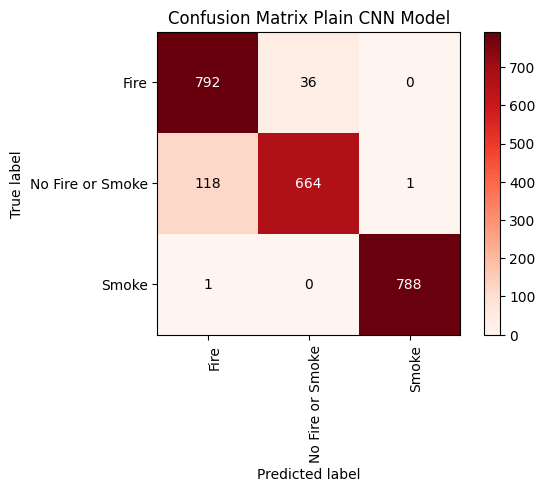

In [ ]:
# PLAIN CNN

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, predicted_classes)

fig, axes = plt.subplots()
plot = axes.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Reds)
axes.figure.colorbar(plot, ax=axes)
axes.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]), xticklabels=class_names, yticklabels=class_names, ylabel='True label', xlabel='Predicted label')
plt.setp(axes.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

for row_id in range(conf_mat.shape[0]):
    for col_id in range(conf_mat.shape[1]):
        axes.text(col_id, row_id, format(conf_mat[row_id, col_id], 'd'), ha="center", va="center", color="white" if conf_mat[row_id, col_id] > conf_mat.max() / 2. else "black")
        
fig.tight_layout()
axes.set_title("Confusion Matrix Plain CNN Model"); pass

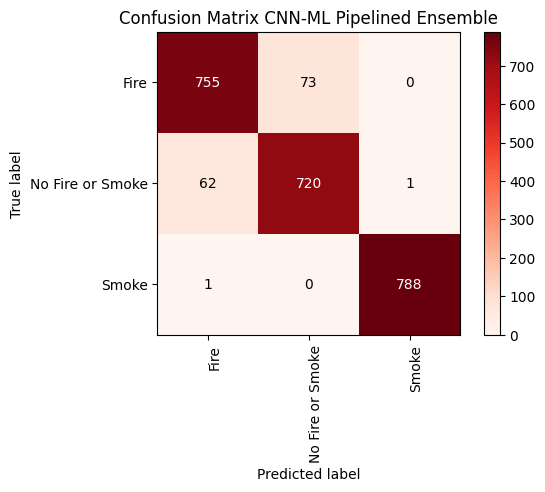

In [ ]:
# CNN PIPELINED ENSEMBLE

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, predicted_classes_dt)

fig, axes = plt.subplots()
plot = axes.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Reds)
axes.figure.colorbar(plot, ax=axes)
axes.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]), xticklabels=class_names, yticklabels=class_names, ylabel='True label', xlabel='Predicted label')
plt.setp(axes.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

for row_id in range(conf_mat.shape[0]):
    for col_id in range(conf_mat.shape[1]):
        axes.text(col_id, row_id, format(conf_mat[row_id, col_id], 'd'), ha="center", va="center", color="white" if conf_mat[row_id, col_id] > conf_mat.max() / 2. else "black")
        
fig.tight_layout()
axes.set_title("Confusion Matrix CNN-ML Pipelined Ensemble"); pass

## Showing the plain correctly and incorrectly predicted imagery

In [ ]:
## Plotting the train and test imagery
def plot_plain_images(data_index):
    f, ax = plt.subplots(3, 3, figsize=(10,10))

    for i, indx in enumerate(data_index[:9]):
        ax[i//3, i%3].imshow(X_test[indx].reshape(128, 128, 3), cmap='gray')
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title("True:{}  Pred:{}".format(class_names[y_test[indx]],class_names[predicted_classes[indx]]))
    plt.show()

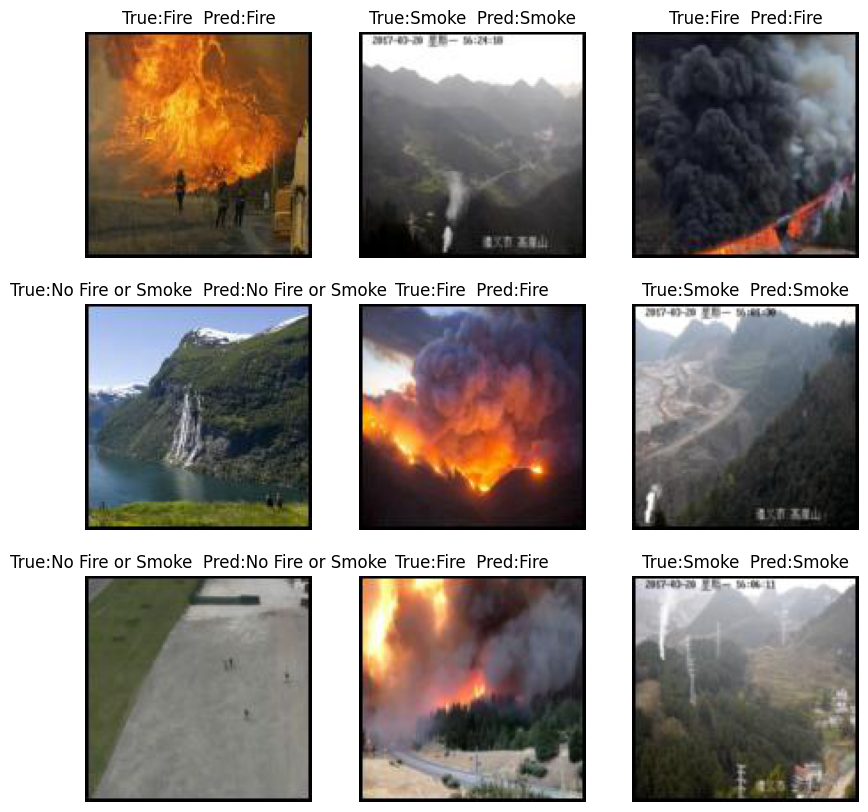

In [ ]:
plot_plain_images(correct_cnn[:10])

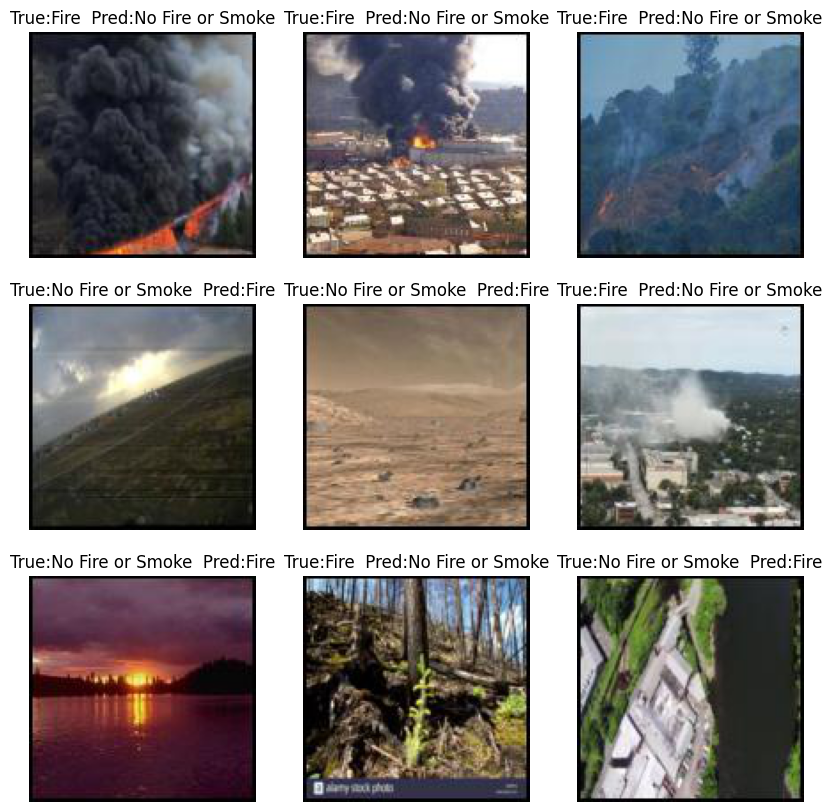

In [ ]:
plot_plain_images(incorrect_cnn[:10])

**Save the h5 and joblib pipelined model file**

In [ ]:
tf.keras.models.save_model(complete_model, 'models/complete_cnn.h5')

In [ ]:
joblib.dump(dt_pipeline, 'models/dt_pipeline.joblib')

In [ ]:
!git status

In [ ]:
!git add .

In [ ]:
!git commit -m "New model added"

In [ ]:
!git push

# 8. Visualisations

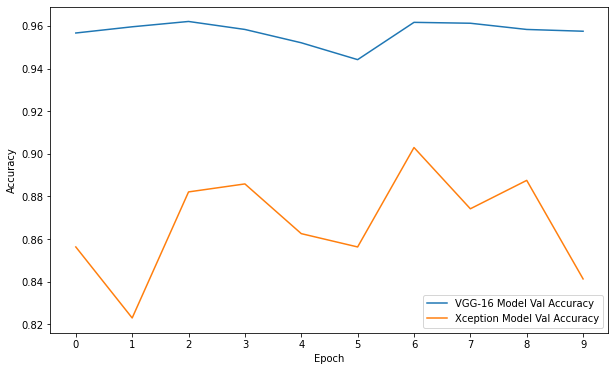

In [ ]:
plt.figure(figsize=(10, 6))

#plt.plot(history_base.history['val_accuracy'], label='Base Model Val Accuracy')
#plt.plot(history_complete.history['val_accuracy'], label='Complete Model Val Accuracy')
plt.plot(vgg_model.history['val_accuracy'], label='VGG-16 Model Val Accuracy')
plt.plot(xception_model.history['val_accuracy'], label='Xception Model Val Accuracy')
#plt.plot(resnet_model.history['val_accuracy'], label='ResNet152 Model Val Accuracy')

plt.xlabel('Epoch')
plt.xticks(range(0, 10))
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

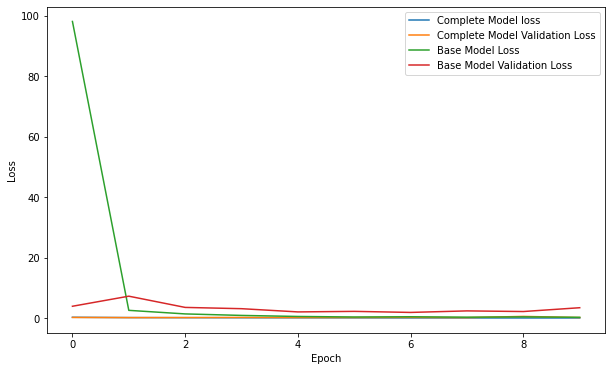

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history_complete.history['loss'], label='Complete Model loss')
plt.plot(history_complete.history['val_loss'], label='Complete Model Validation Loss')
plt.plot(history_base.history['loss'], label='Base Model Loss')
plt.plot(history_base.history['val_loss'], label='Base Model Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

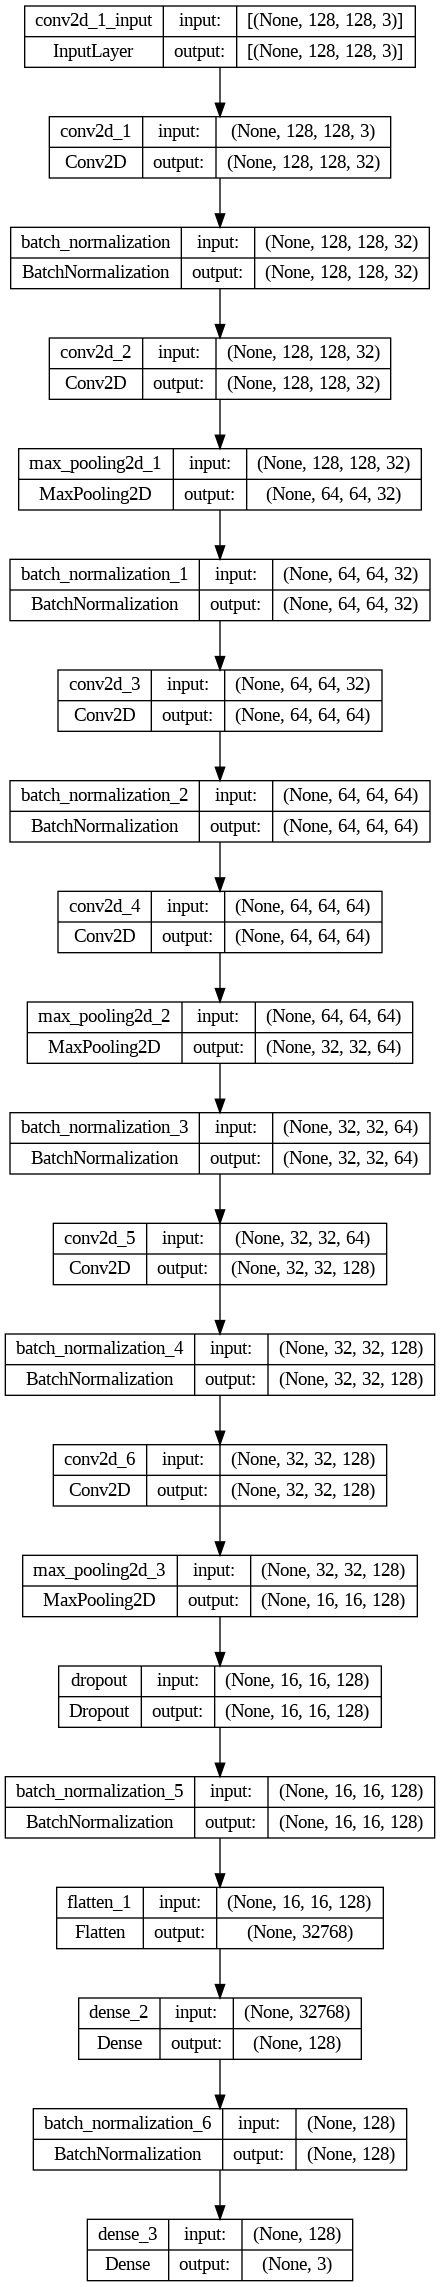

In [ ]:
from keras.utils import plot_model

# Complete model architecture visualising layers and shapes

# draw the plot using seaborn
plot_model(complete_model, show_shapes=True, show_layer_names=True)

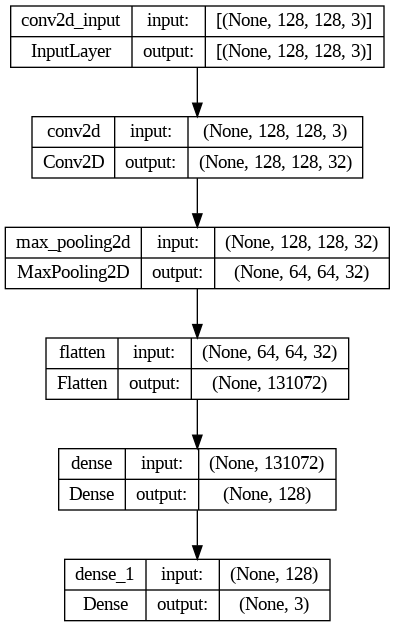

In [ ]:
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [ ]:
type(complete_model)

keras.engine.sequential.Sequential

In [ ]:
xception_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 model_5 (Functional)        (None, 4, 4, 3)           20867627  
                                                                 
 dense_7 (Dense)             (None, 4, 4, 3)           12        
                                                                 
 flatten_1 (Flatten)         (None, 48)                0         
                                                                 
 dense_11 (Dense)            (None, 1024)              50176     
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 3)                 1539

In [ ]:
complete_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                      

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 16.4 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-phd79xj_
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-phd79xj_
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [ ]:
import visualkeras

In [ ]:
# Visualisig our base model

visualkeras.layered_view(base_model, legend=True)

NameError: ignored

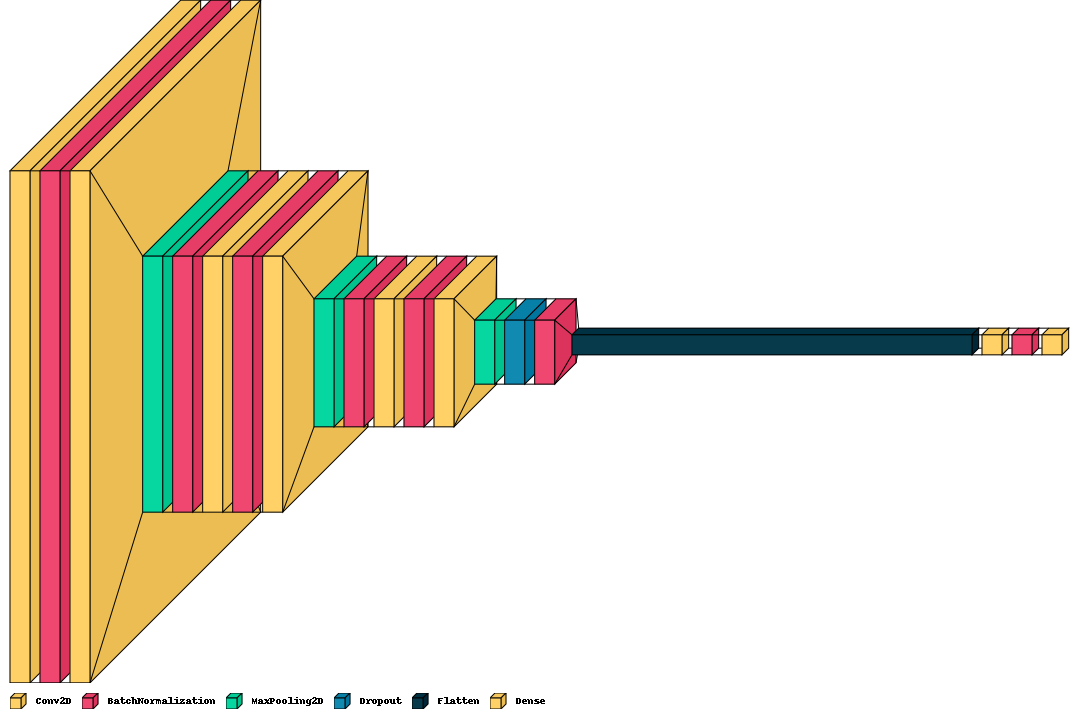

In [ ]:
visualkeras.layered_view(complete_model, legend=True)

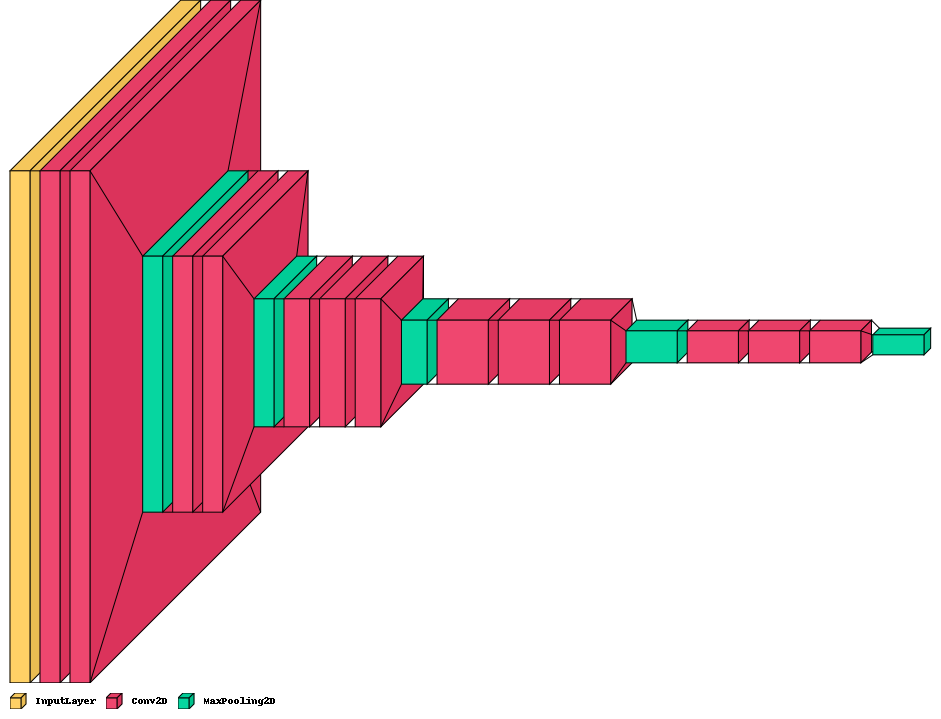

In [ ]:
visualkeras.layered_view(vgg_import, legend=True)